# Molecular dynamics

So far, we have calculated Raman spectra using an approach based on phonons. However, in real systems motion is never perfectly harmonic. For many relevant systems, thermal motion of atoms is strongly anharmonic, meaning that the "wiggles" of the atoms are no longer well-described by phonons. 

To accurately calculate Raman spectra for these systems, we rely on molecular dynamics (MD). The tutorial will demonstrate how to calculate MD-based Raman spectra using ramannoodle, namely `Trajectory` and `InterpolationModel`. 

First, our usual imports. 

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib_inline

import ramannoodle.io.vasp as vasp_io
from ramannoodle.polarizability.art import InterpolationModel
from ramannoodle.spectrum.spectrum_utils import convolve_spectrum

matplotlib_inline.backend_inline.set_matplotlib_formats('png')
plt.rcParams['figure.dpi'] = 300
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams["mathtext.default"] = 'regular'
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['xtick.major.width'] = 0.5
plt.rcParams['xtick.minor.width'] = 0.5
plt.rcParams['lines.linewidth'] = 1.5

Our final goal is to calculate TiO2's Raman spectrum. We will construct an interpolation model just as we did in the basic tutorial. 

In [3]:
data_dir = "../../../test/data/TiO2"
ref_structure = vasp_io.poscar.read_ref_structure(f"{data_dir}/POSCAR")

# We'll need the polarizability of the equilibrium structure. 
_, equilibrium_polarizability = vasp_io.outcar.read_positions_and_polarizability(
   f"{data_dir}/ref_eps_OUTCAR"
)
model = InterpolationModel(ref_structure, equilibrium_polarizability)

# OUTCARS are polarizability calculation where atom 5 (Ti) 
# was displaced +0.1 and +0.2 angstrom in the x direction
model.add_dof_from_files(
    [f"{data_dir}/Ti5_0.1x_eps_OUTCAR", f"{data_dir}/Ti5_0.2x_eps_OUTCAR"],
    file_format = 'outcar', interpolation_order=2)

# atom 5 moving +0.1 and +0.2 angstroms in the z direction
model.add_dof_from_files([f"{data_dir}/Ti5_0.1z_eps_OUTCAR",
                          f"{data_dir}/Ti5_0.2z_eps_OUTCAR"],
                            file_format = 'outcar', interpolation_order=2)

# atom 43 moving in the z direction
model.add_dof_from_files([f"{data_dir}/O43_0.2z_eps_OUTCAR",
                          f"{data_dir}/O43_0.1z_eps_OUTCAR", 
                          f"{data_dir}/O43_m0.1z_eps_OUTCAR", 
                          f"{data_dir}/O43_m0.2z_eps_OUTCAR"], file_format= 'outcar', interpolation_order=2)

model.add_dof_from_files([f"{data_dir}/O43_0.1x_eps_OUTCAR",
                         f"{data_dir}/O43_0.2x_eps_OUTCAR"], 
                         file_format = 'outcar', interpolation_order=2)

model.add_dof_from_files([f"{data_dir}/O43_0.1y_eps_OUTCAR",
                          f"{data_dir}/O43_0.2y_eps_OUTCAR"],
                            file_format = 'outcar', interpolation_order=2)

# We should now have specified all 324 DOFs
model

InterpolationModel with 324/324 degrees of freedom specified.

Our interpolation model is fully specified! Now, we read in an MD trajectory. 

### High quality trajectory

In [4]:
from ramannoodle.dynamics.trajectory import Trajectory

# This trajectory is not publicly available. Sorry! If you want to follow along in your # own notebook, scroll further.
trajectory = vasp_io.vasprun.read_trajectory(
    f"/Volumes/Untitled/md/TiO2/production.xml"
)

In [5]:
# Compute spectrum
spectrum = trajectory.get_raman_spectrum(model)

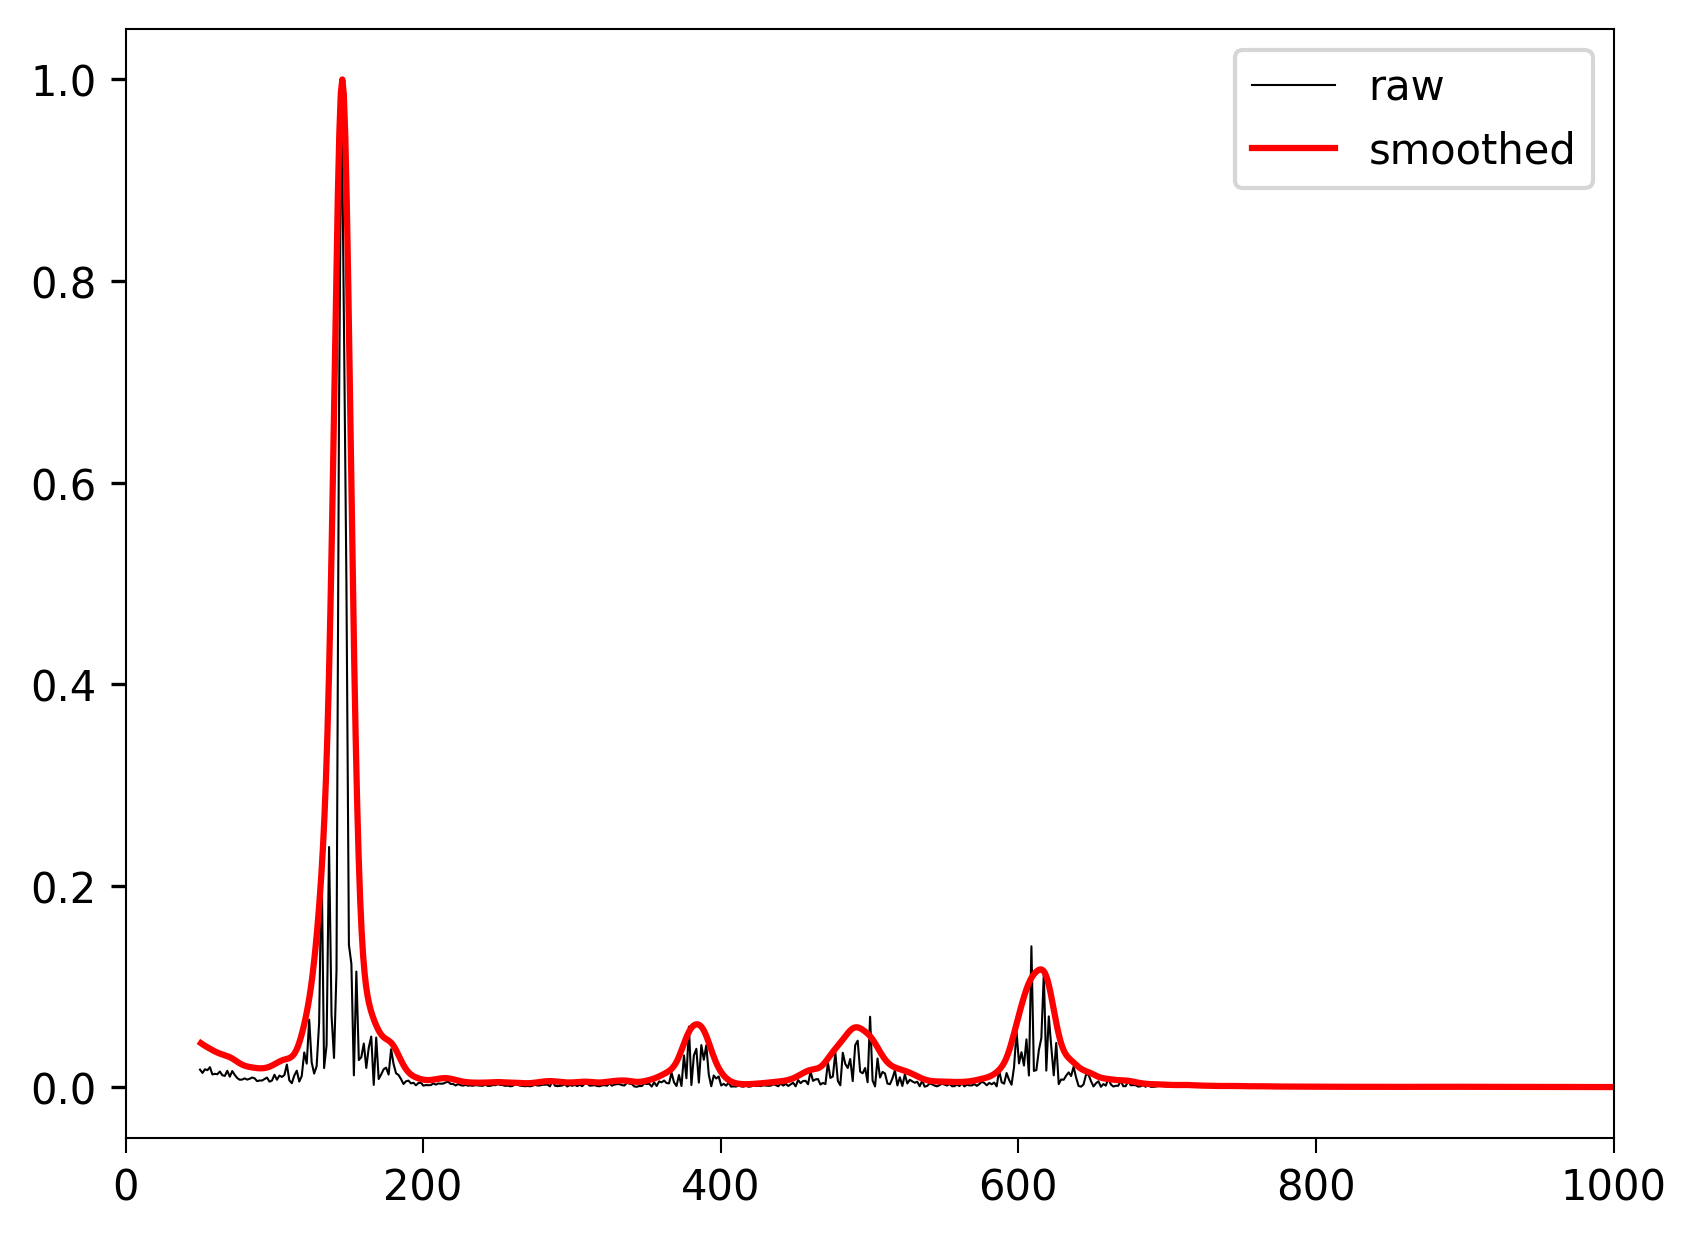

In [6]:
# Then plot
wavenumbers, total_intensities = spectrum.measure(laser_correction = True, 
                                           laser_wavelength = 532, 
                                           bose_einstein_correction = True, 
                                           temperature = 300)
fig = plt.figure()
axis = fig.add_subplot(111)
axis.plot(
    wavenumbers[wavenumbers > 50], 
    total_intensities[wavenumbers > 50] / np.max(total_intensities[wavenumbers > 50]), 
    label = "raw", color = 'black', linewidth = 0.5
)
wavenumbers, total_intensities = convolve_spectrum(wavenumbers, total_intensities)
axis.plot(
    wavenumbers[wavenumbers > 50], 
    total_intensities[wavenumbers > 50] / np.max(total_intensities[wavenumbers > 50]), 
    label = "smoothed", color = "red"
)

axis.set_xlim((0,1000))
l = axis.legend()

A few comments. First, note that MD-derived Raman spectra are somewhat noisy (black curve). This noise can be effectively removed for visualization using ``convolve_spectrum`` (red curve). Second, note how we defined a lower cutoff for wavenumbers and intensities; we chose 50 cm-1. This is because inclusion of the laser wavelength correction terms (``laser_correction = True``) leads to large intensities at 0 cm-1. This artifact makes spectra difficult to visualize, but we are safe to remove it.

### Lower quality, publicly available trajectory 

Let's repeat the above steps using a TiO2 trajectory available in the ramannoodle repo.

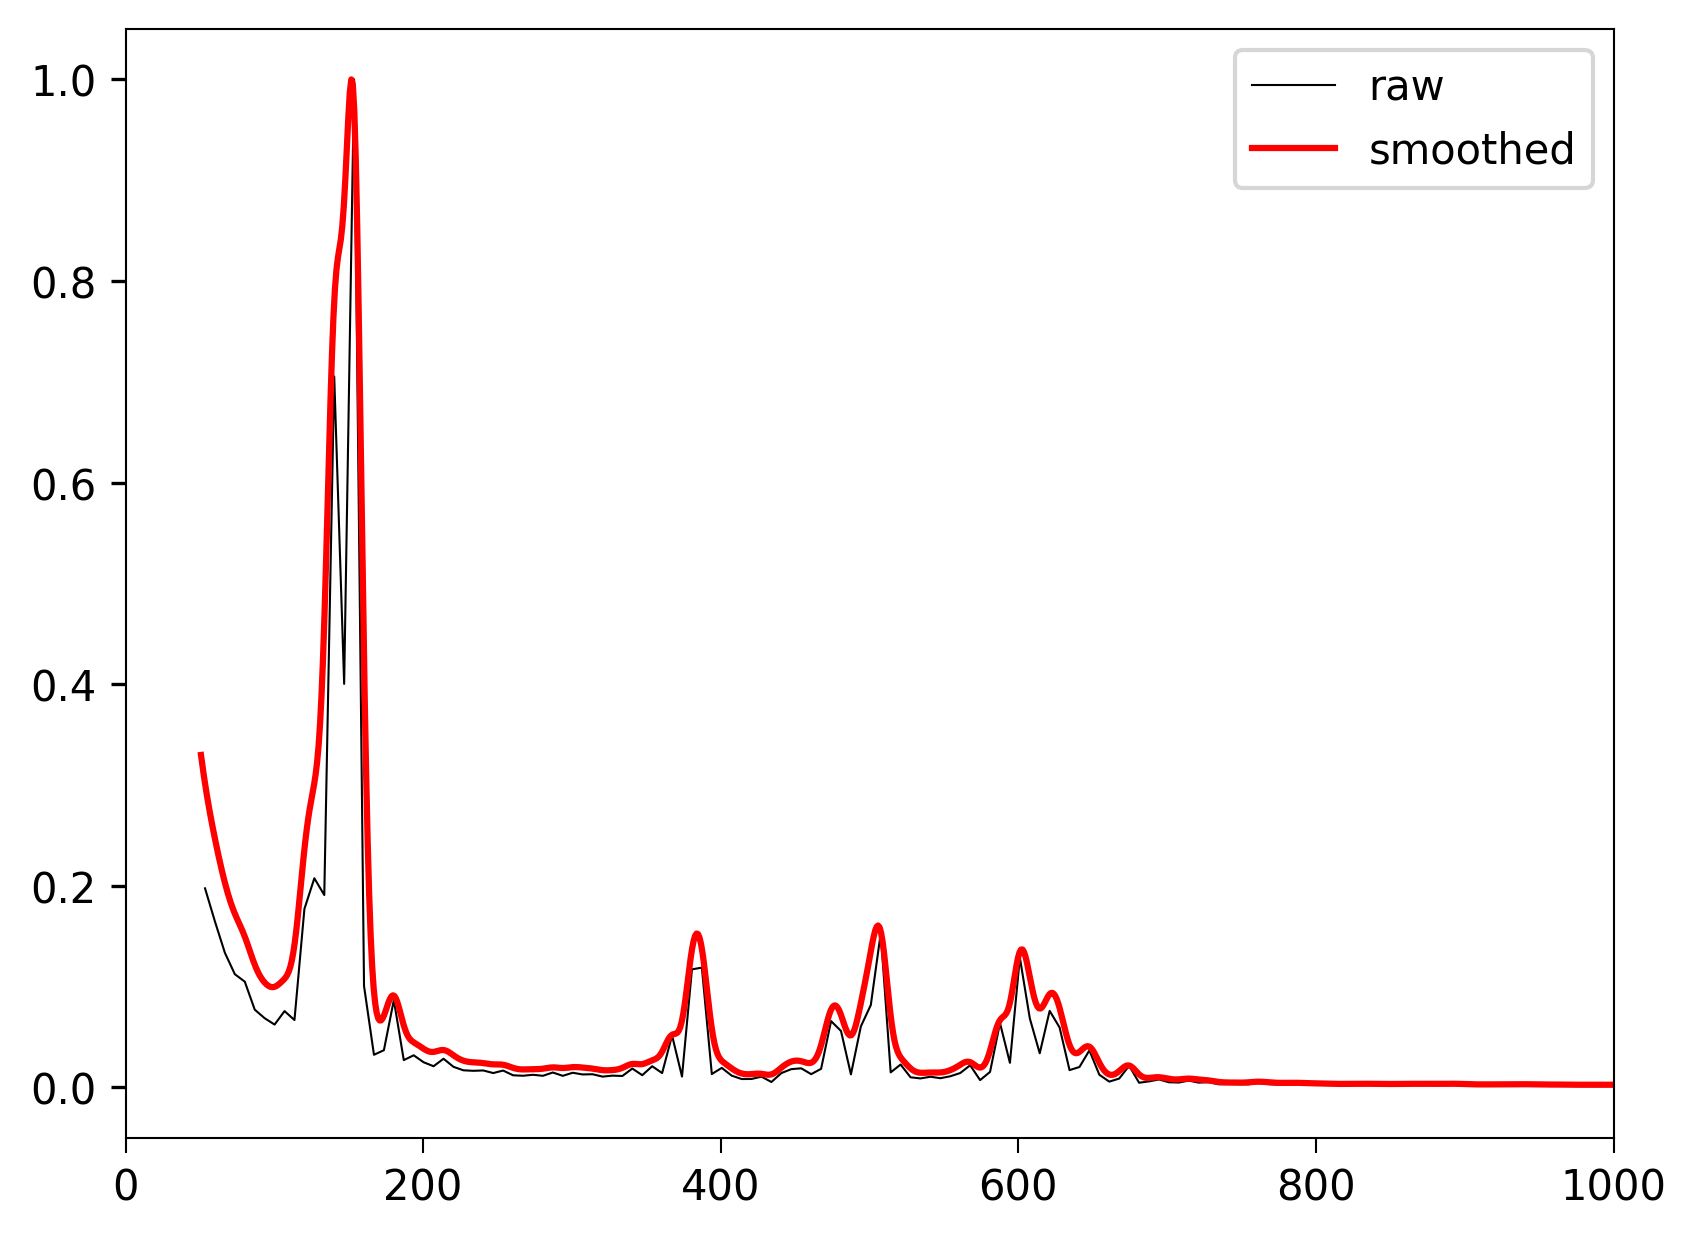

In [16]:
from ramannoodle.dynamics.trajectory import Trajectory


trajectory = vasp_io.xdatcar.read_trajectory(
    f"{data_dir}/MD_trajectory_XDATCAR", timestep = 5
)

# Compute spectrum
spectrum = trajectory.get_raman_spectrum(model)

# Then plot
wavenumbers, total_intensities = spectrum.measure(laser_correction = True, 
                                           laser_wavelength = 532, 
                                           bose_einstein_correction = True, 
                                           temperature = 300)
fig = plt.figure()
axis = fig.add_subplot(111)
axis.plot(
    wavenumbers[wavenumbers > 50], 
    total_intensities[wavenumbers > 50] / np.max(total_intensities[wavenumbers > 50]), 
    label = "raw", color = 'black', linewidth = 0.5
)
wavenumbers, total_intensities = convolve_spectrum(wavenumbers, total_intensities)
axis.plot(
    wavenumbers[wavenumbers > 50], 
    total_intensities[wavenumbers > 50] / np.max(total_intensities[wavenumbers > 50]), 
    label = "smoothed", color = "red"
)

axis.set_xlim((0,1000))
l = axis.legend()